In [1]:
# ------- DEEPFAKE VIDEO DETECTION - TRIPLET LOSS -------
# --- Rebuild to notebooks environtment & Enhanced by ---
# ----------------- ADZANO ELANG SAPUTRO ----------------

# Import Library yang diperlukan untuk embed-image
import numpy as np
import keras.utils as imageutils
import pandas as pd
from keras_facenet import FaceNet

In [3]:
# ----- Ambil Data CSV -----
# --- Pisahkan data kedalam variabel images dan labels dalam bentuk array ---
# Data dalam CSV harus memiliki 2 kolom ("images_list" dan "label")
#
# "images_list" harus berisi absolute path dari gambar wajah beformat jpg yang telah di crop (dengan ekstraksi fitur/lainnya)
# "label" harus berisi label dari data gambar yang berupa nilai "0" untuk wajah palsu,"1" untuk wajah asli
data = pd.read_csv("C:\\Users\\zanog\\Documents\\Projects\\deepfake-detection\\train_faces_25frames.csv")

images = data["images_list"]
labels = data["label"]

# Deklarasi Awal Variabel untuk iterasi
train_data = []
train_label = []
count = 0

In [4]:
embedder = FaceNet() # Input fungsi Emmbedder yang digunakan
#
# ----- FaceNet -----
# Facenet digunakan untuk menghasilkan representasi unik berupa embeddings dari setiap wajah dalam gambar.
# Facenet memetakan gambar wajah menjadi eucledian space, dimana jarak(space) dari eucledian tersebut mewakili kesamaan wajah
# Hasil embedding dapat disebut sebagai "feature vector"
# Dengan representasi tersebut, nantinya wajah wajah dapat dibandingkan dengan menghitung jarak kosinus atau eucledian antara embedding mereka nantinya

In [5]:
# Mulai iterasi untuk menghasilkan embedding dari dataset yang telah dimuat
for (img_path, label) in zip(images, labels): # iterasi semua file dalam array
    img = imageutils.load_img(img_path) # muat gambar dari direktori
    x = imageutils.img_to_array(img) # ubah format gambar menjadi array dan simpan ke variabel x
    x = np.expand_dims(x, axis=0) # tambahkan besaran dimensi dari array x. axis 0 = tambah dimensi di awal array/indeks 0
    embeddings = embedder.embeddings(x) # aplikasikan facenet kedalam array x untuk mengisi dimensi yang telah dibuat tadi
    train_data.append(embeddings) # gabungkan hasil embeddings kedalam array train_data 
    # train_label += [label.argmax(1)]
    train_label.append(label) # muat dan simpan label dari csv diatas kedalam arrat train_label

    if count % 100 == 0:
        print("Number of files done:", count) # counter
    count += 1

# Simpan array dalam bentuk konfigurasi NumPy Array
train_data = np.array(train_data) 
train_label = np.array(train_label)
print("Embedding Files Done...")

1/1 [==============================] - 3s 3s/step
Number of files done: 0
1/1 [==============================] - 0s 88ms/step
Number of files done: 100
1/1 [==============================] - 0s 92ms/step
Number of files done: 200
1/1 [==============================] - 0s 87ms/step
Number of files done: 300
1/1 [==============================] - 0s 88ms/step
Number of files done: 400
1/1 [==============================] - 0s 89ms/step
Number of files done: 500
1/1 [==============================] - 0s 92ms/step
Number of files done: 600
1/1 [==============================] - 0s 92ms/step
Number of files done: 700
1/1 [==============================] - 0s 93ms/step
Number of files done: 800
1/1 [==============================] - 0s 96ms/step
Number of files done: 900
1/1 [==============================] - 0s 93ms/step
Number of files done: 1000
1/1 [==============================] - 0s 93ms/step
Number of files done: 1100
1/1 [==============================] - 0s 93ms/step
Number of file

In [6]:
# --- Contoh Output Hasil Embeddings Menggunakan FaceNet ---
print(train_data[0]) 

[[-2.02789381e-02  8.72470625e-03 -5.77636510e-02 -1.59202907e-02
  -2.39796806e-02 -3.34819872e-03  2.57982034e-02 -5.53313196e-02
   7.14606419e-02  4.89805155e-02  3.40319462e-02  3.14552486e-02
   1.00076506e-02  3.46817495e-03 -4.41207886e-02  1.77212954e-02
  -1.33027844e-02  1.91314926e-03  7.69827887e-02  2.95139775e-02
   1.17475204e-02 -7.83921778e-02  1.42840305e-02  3.22422832e-02
  -1.45898052e-02  2.26379447e-02 -2.93514635e-02 -8.65833685e-02
  -7.55264387e-02 -3.07879839e-02  1.47682941e-02 -1.80189349e-02
  -3.56087126e-02  6.01115962e-03 -8.91806092e-03 -2.63982248e-02
   7.18558580e-02 -7.15311011e-03  5.27707115e-02  3.55928205e-02
  -3.76281291e-02 -4.90058959e-02 -1.44845873e-01  6.91105947e-02
  -4.06818837e-02 -9.32928640e-03  9.66925174e-03  8.36718380e-02
   4.24395688e-02  9.96461604e-03 -6.85275048e-02  1.47214718e-02
  -9.25180316e-02 -7.58660259e-03 -1.37361027e-02  3.14848162e-02
   9.17387847e-03 -4.78406809e-02 -3.95633653e-02 -3.44640613e-02
  -7.91406

In [7]:
# --- Simpan NumPy Array dalam bentuk .npy ---
np.save("train_data_facenet_embeddings_0axis.npy", train_data)
np.save("train_label_facenet_embeddings_0axis.npy", train_label)
print("All data successfully embedded!")
print("Files saved...")

All data successfully embedded!
Files saved...


In [8]:
# ----- Mulai Proses Training Triplet Loss -----
# --- Load Library yang dibutuhkan ---
import argparse
import pickle

## -- Untuk Model definition/training:
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, concatenate,  Dropout, Embedding
from keras.optimizers import Adam, Nadam
from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
# from keras.applications.resnet_v2 import ResNet50V2
from keras import backend as K
# from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers.pooling import MaxPooling2D

## -- Library untuk semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## -- Untuk Visualisasi Data:
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [9]:
# --- Definisikan Scatter Plot untuk keperluan Visualisasi ---
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # warna elemen pada plot

def scatter(x, labels, subtitle=None):
	# Pilih color pallete dari seaborn
	palette = np.array(sns.color_palette(flatui, 2))

	# Buat scatter plot
	f = plt.figure(figsize=(8, 8))
	ax = plt.subplot(aspect="equal")
	sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[labels.astype(np.int)])
	plt.xlim(-25, 25)
	plt.ylim(-25, 25)
	ax.axis("off")
	ax.axis("tight")

	# Tambahkan labels pada setiap digit 
	txts = []
	for i in range(2):
		# Posisi dari setiap label
		xtext, ytext = np.median(x[labels == i, :], axis=0)
		txt = ax.text(xtext, ytext, str(i), fontsize=24)
		txt.set_path_effects(
			[PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()]
		)
		txts.append(txt)

	if subtitle != None:
		plt.suptitle(subtitle)

	plt.savefig(subtitle)


In [10]:
# Definisikan Pairwise Distance Matrix
def pairwise_distance(feature, squared=False):
	"""Computes the pairwise distance matrix with numerical stability.

	output[i, j] = || feature[i, :] - feature[j, :] ||_2

	Args:
	  feature: 2-D Tensor of size [number of data, feature dimension].
	  squared: Boolean, whether or not to square the pairwise distances.

	Returns:
	  pairwise_distances: 2-D Tensor of size [number of data, number of data].
	"""
	pairwise_distances_squared = math_ops.add(
		math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
		math_ops.reduce_sum(
			math_ops.square(array_ops.transpose(feature)),
			axis=[0],
			keepdims=True)) - 2.0 * math_ops.matmul(feature,
													array_ops.transpose(feature))

	# Deal with numerical inaccuracies. Set small negatives to zero.
	pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
	# Get the mask where the zero distances are at.
	error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

	# Optionally take the sqrt.
	if squared:
		pairwise_distances = pairwise_distances_squared
	else:
		pairwise_distances = math_ops.sqrt(
			pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

	# Undo conditionally adding 1e-16.
	pairwise_distances = math_ops.multiply(
		pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

	num_data = array_ops.shape(feature)[0]
	# Explicitly set diagonals to zero.
	mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
		array_ops.ones([num_data]))
	pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
	return pairwise_distances

In [11]:
# Definisikan Masked Maximum
def masked_maximum(data, mask, dim=1):
	"""Computes the axis wise maximum over chosen elements.

	Args:
	  data: 2-D float `Tensor` of size [n, m].
	  mask: 2-D Boolean `Tensor` of size [n, m].
	  dim: The dimension over which to compute the maximum.

	Returns:
	  masked_maximums: N-D `Tensor`.
		The maximized dimension is of size 1 after the operation.
	"""
	axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
	masked_maximums = math_ops.reduce_max(
		math_ops.multiply(data - axis_minimums, mask), dim,
		keepdims=True) + axis_minimums
	return masked_maximums

In [12]:
# Definisikan Masked Minimum
def masked_minimum(data, mask, dim=1):
	"""Computes the axis wise minimum over chosen elements.

	Args:
	  data: 2-D float `Tensor` of size [n, m].
	  mask: 2-D Boolean `Tensor` of size [n, m].
	  dim: The dimension over which to compute the minimum.

	Returns:
	  masked_minimums: N-D `Tensor`.
		The minimized dimension is of size 1 after the operation.
	"""
	axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
	masked_minimums = math_ops.reduce_min(
		math_ops.multiply(data - axis_maximums, mask), dim,
		keepdims=True) + axis_maximums
	return masked_minimums

In [13]:
# Definisikan Triplet Loss berdasarkan TensorFlow
def triplet_loss_adapted_from_tf(y_true, y_pred):
	del y_true
	margin = 1.
	labels = y_pred[:, :1]

 
	labels = tf.cast(labels, dtype='int32')

	embeddings = y_pred[:, 1:]

	### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
	
	# Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
	# lshape=array_ops.shape(labels)
	# assert lshape.shape == 1
	# labels = array_ops.reshape(labels, [lshape[0], 1])

	# Build pairwise squared distance matrix.
	pdist_matrix = pairwise_distance(embeddings, squared=True)
	# Build pairwise binary adjacency matrix.
	adjacency = math_ops.equal(labels, array_ops.transpose(labels))
	# Invert so we can select negatives only.
	adjacency_not = math_ops.logical_not(adjacency)

	# global batch_size  
	batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

	# Compute the mask.
	pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
	mask = math_ops.logical_and(
		array_ops.tile(adjacency_not, [batch_size, 1]),
		math_ops.greater(
			pdist_matrix_tile, array_ops.reshape(
				array_ops.transpose(pdist_matrix), [-1, 1])))
	mask_final = array_ops.reshape(
		math_ops.greater(
			math_ops.reduce_sum(
				math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
			0.0), [batch_size, batch_size])
	mask_final = array_ops.transpose(mask_final)

	adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
	mask = math_ops.cast(mask, dtype=dtypes.float32)

	# negatives_outside: smallest D_an where D_an > D_ap.
	negatives_outside = array_ops.reshape(
		masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
	negatives_outside = array_ops.transpose(negatives_outside)

	# negatives_inside: largest D_an.
	negatives_inside = array_ops.tile(
		masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
	semi_hard_negatives = array_ops.where(
		mask_final, negatives_outside, negatives_inside)

	loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

	mask_positives = math_ops.cast(
		adjacency, dtype=dtypes.float32) - array_ops.diag(
		array_ops.ones([batch_size]))

	# In lifted-struct, the authors multiply 0.5 for upper triangular
	#   in semihard, they take all positive pairs except the diagonal.
	num_positives = math_ops.reduce_sum(mask_positives)

	semi_hard_triplet_loss_distance = math_ops.truediv(
		math_ops.reduce_sum(
			math_ops.maximum(
				math_ops.multiply(loss_mat, mask_positives), 0.0)),
		num_positives,
		name='triplet_semihard_loss')
	
	### Code from Tensorflow function semi-hard triplet loss ENDS here.
	return semi_hard_triplet_loss_distance

In [14]:
# definisikan fungsi utama Triplet Loss
def triplets_loss(y_true, y_pred):
	
#     embeddings = K.cast(embeddings, 'float32')
#     with sess.as_default():
#         print(embeddings.eval())
	
	embeddings = y_pred
	anchor_positive = embeddings[:10]
	negative = embeddings[10:]
#     print(anchor_positive)

	# Compute pairwise distance between all of anchor-positive
	dot_product = K.dot(anchor_positive, K.transpose(anchor_positive))
	square = K.square(anchor_positive)
	a_p_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product  + K.sum(K.transpose(square), axis=0) + 1e-6
	a_p_distance = K.maximum(a_p_distance, 0.0) ## Numerical stability
#     with K.get_session().as_default():
#         print(a_p_distance.eval())
#     print("Pairwise shape: ", a_p_distance)
#     print("Negative shape: ", negative)

	# Compute distance between anchor and negative
	dot_product_2 = K.dot(anchor_positive, K.transpose(negative))
	negative_square = K.square(negative)
	a_n_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product_2  + K.sum(K.transpose(negative_square), axis=0)  + 1e-6
	a_n_distance = K.maximum(a_n_distance, 0.0) ## Numerical stability
	
	hard_negative = K.reshape(K.min(a_n_distance, axis=1), (-1, 1))
	
	distance = (a_p_distance - hard_negative + 0.2)
	loss = K.mean(K.maximum(distance, 0.0))/(2.)

#     with K.get_session().as_default():
#             print(loss.eval())
			
	return loss

In [15]:
# Buat Base Network atau Network dasar yang akan digunakan untuk ekstraksi fitur dan sebagainya.
def create_base_network(image_input_shape, embedding_size):
	"""
	Base network to be shared (eq. to feature extraction).
    - Network dasar ini merubah fungsi linear yang dihasilkan dari array gambar sebelumnya menjadi non-linear.
    - Tanpa adanya fungsi aktivasi non-linear maka nilai array akan hanya berupa kombinasi nilai linear berapapun jumlah layernya.
    
    Dalam base network ini digunakan Deep Neural Network dengan fungsi aktivasi ReLU
    - DNN disini terbagi menjadi beberapa langkah dengan dense layer/fully connected layer.
    - Kernel initializer dibutuhkan untuk inisialisasi berat layer diatas
	"""
	main_input = Input(shape=(image_input_shape))
	x = Dense(256, activation='relu', kernel_initializer='he_uniform')(main_input) # menambahkan dense layer dengan 256 neurons dengan fungsi aktivasi ReLU
	x = Dropout(0.1)(x) # aplikasikan dropout regularisasi dengan rate 0.1 pada output layer sblmnya untuk mencegah overfitting. ini bekerja dengan secara acak menyiapkan fraksi atau bagian dari unit input ke 0 saat training
	x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x) # mengulangi utk menambahkan dense layer dengan 256 neurons dengan fungsi aktivasi ReLU
	x = Dropout(0.1)(x) # aplikasikan dropout regularisasi dengan rate 0.1 pada output layer sblmnya untuk mencegah overfitting. ini bekerja dengan secara acak menyiapkan fraksi atau bagian dari unit input ke 0 saat training
	x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x) # mengulangi utk menambahkan dense layer dengan 128 neurons dengan fungsi aktivasi ReLU
	x = Dropout(0.1)(x) # aplikasikan dropout regularisasi dengan rate 0.1 pada output layer sblmnya untuk mencegah overfitting. ini bekerja dengan secara acak menyiapkan fraksi atau bagian dari unit input ke 0 saat training
	embeddings = Dense(embedding_size)(x) # hasil layer akhir merupakan dense layer dengan embedding_size neurons yang mana menghasilkan embedding vector seukuran dengan ukuran array embedding_size

	base_network = Model(inputs= main_input, outputs=embeddings)

	return base_network

In [18]:
# ---------------- MULAI FUNGSI UTAMA TRAINING TRIPLET LOSS ---------------
# -------------------------- TERDAPAT 2 KONDISI : -------------------------
# ------------ 1. Training Triplets (isikan trainflag ("True")) -----------
# ----- 2. Testing Triplets + Classifier (isikan trainflag ("False")) -----
# -- PERHATIAN! hanya isikan selain "True" jika model sudah di training! --

# -- Persiapan Variabel
batch_size = 32 # untuk peningkatan kecepatan sistem saat training, maka dilakukan batch processing/preses secara bersamaan
epochs = 10 # jumlah epoch
train_flag = ("True") # Isikan :     True utk training atau False utk validation
print(f"Train set to: {train_flag}")

embedding_size = 64 # Ukuran Embed Gambar
no_of_components = 2  # untuk visualsasi -> PCA.fit_transform()
step = 10 # Untuk visualisasi selain tSNE

# -- Load data dari Numpy array kedalam array berikut
train_data = np.load("train_data_facenet_embeddings_0axis.npy")
train_label = np.load("train_label_facenet_embeddings_0axis.npy")
print("Dataset Loaded...")

# -- Pecah data/split data kedalam 4 var. baru (x = nilai embed gambar, y = label)
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, 
											  test_size=0.1, stratify=train_label,
											  random_state=34)

# Perkecil shape index array (x) dengan np.squeeze untuk membuang dimensi yg tidak terpakai
x_train = np.squeeze(x_train)
x_test = np.squeeze(x_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Nilai ukuran bentuk gambar. digunakan 512-dimentional embeddings
input_image_shape = (512, )

# -- Pembagian pengambilan data
# Pengambilan data untuk validation set saat training (misal ingin mengambil sejumlah x, maka (:x))
x_val = x_test[:250, :]
y_val = y_test[:250]
# Pengambilan data untuk final test set untuk evaluasi setelah training (ambil sisa dari val. (x:))
x_test = x_test[250:, :]
y_test = y_test[250:]

print("--------for validation---------")
print(x_val.shape, y_val.shape)
print("----------for testing----------")
print(x_test.shape, y_test.shape)

# --- Network training...
if train_flag == "True":
	base_network = create_base_network(input_image_shape, embedding_size)
	for layer in base_network.layers:
		if layer.name.endswith('bn'): # bn = Batch Normalization
			# print(layer.name)
			layer.trainable=False # bn tidak ikut training karena nilai bn telah dinormalisasi. dilakukan untuk mencegah trainable params berubah saat training. ini dikarenakan kita menggunakan pretrained model sebelumnya dan juga untuk menstabilkan data pada dataset yang kecil.
	base_network.summary()

	input_images = Input(shape=input_image_shape, name='input_image') # input layer untuk gambar/images
	input_labels = Input(shape=(1,), name='input_label') # input layer untuk label
	
	embeddings = base_network([input_images])               # output of network -> embeddings
	labels_plus_embeddings = concatenate([input_labels, embeddings]) # gabungkan label dengan hasil embedding

	# Defining a model with inputs (images, labels) and outputs (labels_plus_embeddings)
	# definisikan model dengan input berupa gambar dan label dan output berupa label dengan hasil embedding
    model = Model(inputs=[input_images, input_labels],
				  outputs=labels_plus_embeddings)
	# model.summary()
    # simpan grafik plot model
	plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

	# --- Train session ---
    # --- Deklarasi Optimizer ---
    # Dalam Deep Learning, optimizer memiliki peran penting dalam proses training.
    # tujuan utamanya untuk menyesuaikan parameter-model (bobot dan bias) selama proses pelatihan untuk meminimalkan fungsi kerugian yang telah ditentukan. Tujuan utamanya adalah mencari set parameter optimal yang dapat menghasilkan prediksi yang lebih baik dan generalisasi pada data yang belum pernah dilihat sebelumnya.
	# Adam  = Adaptive Moment Estimation => perluasan dari stochastic gradient descent (SGD) dan merupakan optimizer paling umum dalam Deep Learning
    # lr = learning rate =>  hyperparameter yang mengontrol ukuran langkah di mana optimizer menyesuaikan parameter-model selama setiap iterasi training.
    # 3e-4 (0,0003), adalah titik awal yang umum digunakan untuk Adam
    optimizer = Adam(lr=3e-4)

    # siapkan/compile model untuk proses training
	model.compile(loss=triplet_loss_adapted_from_tf,
				  optimizer=optimizer)

	# Uses 'dummy' embeddings + dummy gt labels. Will be removed as soon as loaded, to free memory
	# Inisialisasi variabel palsu => berisi matriks nol dengan ukuran = x, ukuran embedding + 1 
    # ini diperlukan karena triplet mengharapkan input gambar anchor, positif dan negatif. sedangkan disini akan diberi 2 input berupa gambar(anchor) den label (positif/negatif). oleh karena itu disiapkan target palsu sebagai gantinya.
    # variabel ini sama sekali tidak memiliki peran dalam proses aktual pembelajaran jaringan Siamese atau dalam menghitung nilai fungsi loss. Mereka hanya dibutuhkan untuk menyediakan bentuk yang benar agar kode pelatihan dapat berjalan tanpa kesalahan. Nilai yang sebenarnya dari target palsu tidak digunakan dalam kode ini karena triplet loss secara inheren menghitung jarak antara anchor, positive, dan negative, tanpa menggunakan label sebenarnya.
    dummy_gt_train = np.zeros((len(x_train), embedding_size + 1))
	dummy_gt_val = np.zeros((len(x_val), embedding_size + 1))

	# Mulai Proses Training...
    H = model.fit(
		x=[x_train,y_train],
		y=dummy_gt_train,
		batch_size=batch_size,
		epochs=epochs,
		validation_data=([x_val, y_val], dummy_gt_val)
		# callbacks=callbacks_list
		)
	model.save("triplets_semi_hard.hdf5")
	
else:
    # --- Load Model untuk Testing ---
	model_tr = load_model("triplets_semi_hard.hdf5",
		custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})
	print("-------------------------------------")
	print("Model loaded")
    print("Shape model defined below: x_train, y_train, x_test, y_test")
	print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    print("-------------------------------------")

	# -- Test the network
	# - buat empty network
	testing_embeddings = create_base_network(input_image_shape,
											 embedding_size=embedding_size)
	x_train_before = testing_embeddings.predict(x_train)
	x_test_before = testing_embeddings.predict(x_test)

	print("Embeddings before training")
	sgd = linear_model.SGDClassifier(max_iter=50, tol=None)
	sgd.fit(x_train_before, y_train)
	Y_pred = sgd.predict(x_test_before)
	acc_sgd = accuracy_score(y_test, Y_pred)
	print("SGD Acc:", acc_sgd)

    rf = RandomForestClassifier(n_estimators=100)
	rf.fit(x_train_before, y_train)
	y_pred = rf.predict(x_test_before)
	acc_rf = accuracy_score(y_test, y_pred)
	print("RF Acc:", acc_rf)
    
	# Grabbing the weights from the trained network
	for layer_target, layer_source in zip(testing_embeddings.layers, model_tr.layers[2].layers):
		weights = layer_source.get_weights()
		layer_target.set_weights(weights)
		del weights        

	x_train_after = testing_embeddings.predict(x_train)
	x_test_after = testing_embeddings.predict(x_test)
	
    print("-------------------------------------")
	print("Embeddings after training")
    
    # --- Klasifikasi akhir mengunakan metode Klasifikasi Biner ---
    # Stochastic Gradient Descend
	sgd = linear_model.SGDClassifier(max_iter=50, tol=None, loss="log")
	sgd.fit(x_train_after, y_train)
	Y_pred = sgd.predict(x_test_after)
	acc_sgd = accuracy_score(y_test, Y_pred)
	print("SGD Acc:", acc_sgd)
	with open('sgd_classifier.pkl', 'wb') as fid:
		pickle.dump(sgd, fid)

    # Random Forest
	rf = RandomForestClassifier(n_estimators=100)
	rf.fit(x_train_after, y_train)
	y_pred = rf.predict(x_test_after)
	acc_rf = accuracy_score(y_test, y_pred)
	print("RF Acc:", acc_rf)
	with open('rf_classifier.pkl', 'wb') as fid:
		pickle.dump(rf, fid) 

    #   # Logistic Regression
	# logreg = LogisticRegression()
	# logreg.fit(x_train_after, y_train)
	# y_pred = logreg.predict(x_test_after)
	# acc_lg = accuracy_score(y_test, y_pred)
	# print("LG Acc:", acc_lg)

    #    # K Nearest Neighbor
	# knn = KNeighborsClassifier(n_neighbors=10)
	# knn.fit(x_train_after, y_train)
	# y_pred = knn.predict(x_test_after)
	# acc_knn = accuracy_score(y_test, y_pred)
	# print("KNN Acc:", acc_knn)

    #    # Perceptron
	# perceptron = Perceptron(max_iter=15)
	# perceptron.fit(x_train_after, y_train)
	# y_pred = perceptron.predict(x_test_after)
	# acc_per = accuracy_score(y_test, y_pred)
	# print("Perceptron Acc:", acc_per)

    #    # Decision Tree
	# dt = DecisionTreeClassifier()
	# dt.fit(x_train_after, y_train)
	# y_pred = dt.predict(x_test_after)
	# acc_dt = accuracy_score(y_test, y_pred)
	# print("DT Acc:", acc_dt)

    # Tampilkan Perbedaan Distribusi Data sebelum dan sesudah training triplet network
	# Dapat menggunakan t-SNE (isikan "TSNE") atau PCA (isikan "PCA") pada variabel embed
    # t-SNE => t-distributed Stochastic Neighbor Embedding
    # PCA => Principal Component Analysis
    embed = "TSNE" 

	if embed=="TSNE":
		tsne = TSNE()
		train_tsne_embeds_before_train = tsne.fit_transform(x_train_before[:512])
		train_tsne_embeds_after_train = tsne.fit_transform(x_train_after[:512])

		# val_tsne_bf4_train = tsne.fit_transform()

		scatter(train_tsne_embeds_before_train, y_train[:512], "Training Data Sebelum Triplet Loss Training")
		scatter(train_tsne_embeds_after_train, y_train[:512], "Training Data Sesudah Triplet Loss Training")

	else:

		dict_embeddings = {}
		dict_gray = {}
		test_class_labels = np.unique(np.array(y_test))

		pca = PCA(n_components=no_of_components)
		decomposed_embeddings = pca.fit_transform(x_train_after) #x_embeddings
		print(decomposed_embeddings.shape)
		print(decomposed_embeddings[y_test == 1].shape)
		# x_test_reshaped = np.reshape(x_test, (len(x_test), 28 * 28))
		decomposed_gray = pca.fit_transform(x_train_before)
		
		fig = plt.figure(figsize=(16, 8))
		for label in test_class_labels:
			decomposed_embeddings_class = decomposed_embeddings[y_test == label]
			# print("After train")
			# print(decomposed_embeddings_class.shape)
			# print(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0])
			decomposed_gray_class = decomposed_gray[y_test == label]
			# print("Before train")
			# print(decomposed_gray_class.shape)

			plt.subplot(1,2,1)
			plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
			plt.title('before training (embeddings)')
			plt.legend()
			# plt.savefig('before training')

			plt.subplot(1,2,2)
			plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
			plt.title('after @%d epochs' % epochs)
			plt.legend()
			plt.savefig('final learning')

			# plt.show()


Train set to: True
Dataset Loaded...
(4500, 512) (4500,) (500, 512) (500,)
--------for validation---------
(250, 512) (250,)
--------for testing---------
(250, 512) (250,)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)     

C:\Users\zanog\.conda\envs\tfenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Instructions for updating:
Use `tf.cast` instead.
141/141 [==============================] - 6s 21ms/step - loss: 0.8447 - val_loss: 0.5367
Epoch 2/10
141/141 [==============================] - 2s 16ms/step - loss: 0.3328 - val_loss: 0.1003
Epoch 3/10
141/141 [==============================] - 2s 16ms/step - loss: 0.0875 - val_loss: 0.0131
Epoch 4/10
141/141 [==============================] - 2s 16ms/step - loss: 0.0541 - val_loss: 0.0234
Epoch 5/10
141/141 [==============================] - 2s 16ms/step - loss: 0.0279 - val_loss: 0.0035
Epoch 6/10
141/141 [==============================] - 2s 17ms/step - loss: 0.0259 - val_loss: 0.0086
Epoch 7/10
141/141 [==============================] - 2s 16ms/step - loss: 0.0214 - val_loss: 0.0060
Epoch 8/10
141/141 [==============================] - 2s 16ms/step - loss: 0.0136 - val_loss: 0.0031
Epoch 9/10
141/141 [==============================] - 2s 16ms/step - loss: 0.0153 - val_loss: 0.0032
Epoch 10/10
141/141 [==============================]

Train set to: True
Dataset Loaded...
(4500, 512) (4500,) (500, 512) (500,)
--------for validation---------
(250, 512) (250,)
--------for testing---------
(250, 512) (250,)
-------------------------------------
Model loaded
Shape model defined below: x_train, y_train, x_test, y_test
(4500, 512) (4500,) (250, 512) (250,)
-------------------------------------
8/8 [==============================] - 0s 2ms/step
Embeddings before training
SGD Acc: 0.716
RF Acc: 0.98
8/8 [==============================] - 0s 3ms/step
-------------------------------------
Embeddings after training
SGD Acc: 0.996
RF Acc: 0.996


C:\Users\zanog\.conda\envs\tfenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\zanog\.conda\envs\tfenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\zanog\.conda\envs\tfenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\zanog\.conda\envs\tfenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\zanog\.conda\envs\tfenv\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavi

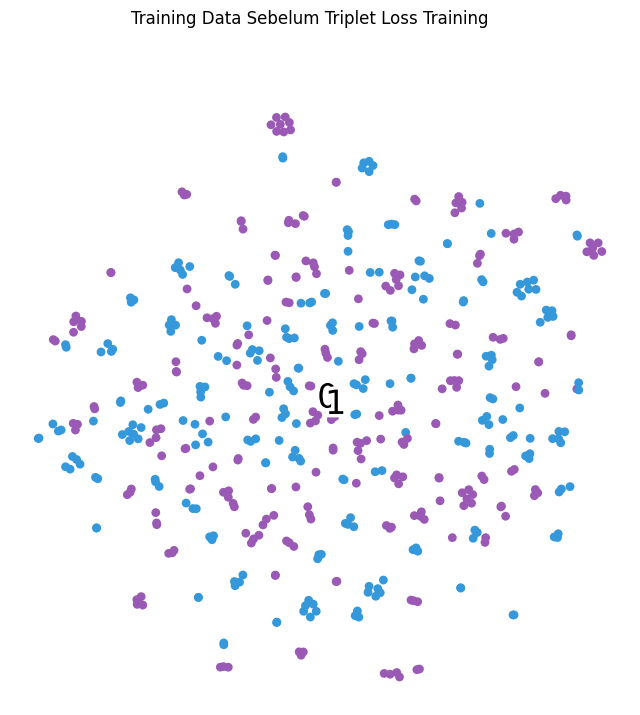

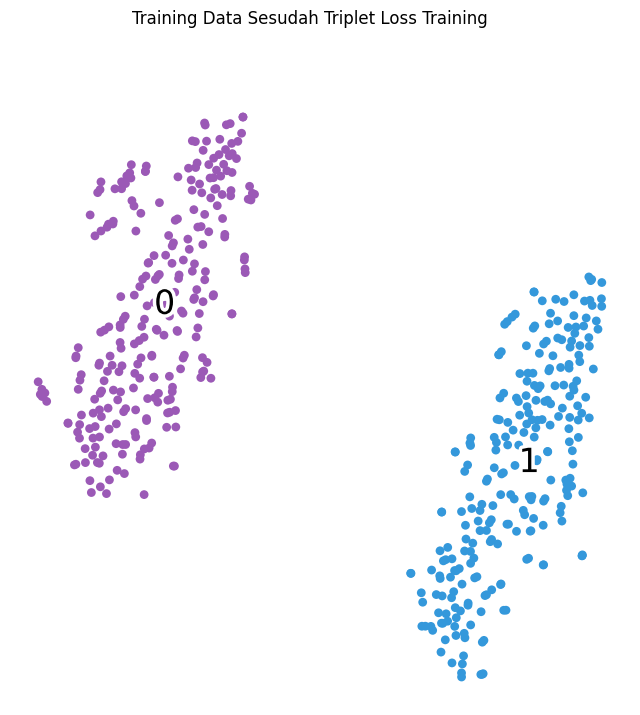

In [29]:
# ---------------------- TESTING TRIPLETS + CLASSIFIER ----------------------------
# ----------- PENTING! ini merupakan fungsi testing untuk model triplet -----------
# -- fungsi ini sama dengan kondisi ke-2/(isikan trainflag ("False") kode diatas --
# ------------- ini dibuat hanya untuk mempermudah running kode saja --------------
# ---- jalankan salah satu -- jika sudah dijalankan diatas, maka skip step ini ----

# -- Persiapan Variabel
batch_size = 32 # untuk peningkatan kecepatan sistem saat training, maka dilakukan batch processing/preses secara bersamaan
epochs = 10 # jumlah epoch
train_flag = ("True") # Isikan :     True utk training atau False utk validation
print(f"Train set to: {train_flag}")

embedding_size = 64 # Ukuran Embed Gambar
no_of_components = 2  # untuk visualsasi -> PCA.fit_transform()
step = 10 # Untuk visualisasi selain tSNE

# -- Load data dari Numpy array kedalam array berikut
train_data = np.load("train_data_facenet_embeddings_0axis.npy")
train_label = np.load("train_label_facenet_embeddings_0axis.npy")
print("Dataset Loaded...")

# -- Pecah data/split data kedalam 4 var. baru (x = nilai embed gambar, y = label)
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, 
											  test_size=0.1, stratify=train_label,
											  random_state=34)

# Perkecil shape index array (x) dengan np.squeeze untuk membuang dimensi yg tidak terpakai
x_train = np.squeeze(x_train)
x_test = np.squeeze(x_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Nilai ukuran bentuk gambar. digunakan 512-dimentional embeddings
input_image_shape = (512, )

# -- Pembagian pengambilan data
# Pengambilan data untuk validation set saat training (misal ingin mengambil sejumlah x, maka (:x))
x_val = x_test[:250, :]
y_val = y_test[:250]
# Pengambilan data untuk final test set untuk evaluasi setelah training (ambil sisa dari val. (x:))
x_test = x_test[250:, :]
y_test = y_test[250:]

print("--------for validation---------")
print(x_val.shape, y_val.shape)
print("--------for testing---------")
print(x_test.shape, y_test.shape)

# --- Load Model untuk Testing ---
model_tr = load_model("triplets_semi_hard.hdf5",
custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})
print("-------------------------------------")
print("Model loaded")
print("Shape model defined below: x_train, y_train, x_test, y_test")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("-------------------------------------")

# -- Test the network
# - buat empty network
testing_embeddings = create_base_network(input_image_shape,
										 embedding_size=embedding_size)
x_train_before = testing_embeddings.predict(x_train)
x_test_before = testing_embeddings.predict(x_test)

print("Embeddings before training")
sgd = linear_model.SGDClassifier(max_iter=50, tol=None)
sgd.fit(x_train_before, y_train)
Y_pred = sgd.predict(x_test_before)
acc_sgd = accuracy_score(y_test, Y_pred)
print("SGD Acc:", acc_sgd)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train_before, y_train)
y_pred = rf.predict(x_test_before)
acc_rf = accuracy_score(y_test, y_pred)
print("RF Acc:", acc_rf)
    
# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model_tr.layers[2].layers):
	weights = layer_source.get_weights()
	layer_target.set_weights(weights)
	del weights        

x_train_after = testing_embeddings.predict(x_train)
x_test_after = testing_embeddings.predict(x_test)

print("-------------------------------------")
print("Embeddings after training")
    
# --- Klasifikasi akhir mengunakan metode Klasifikasi Biner ---
# Stochastic Gradient Descend
sgd = linear_model.SGDClassifier(max_iter=50, tol=None, loss="log")
sgd.fit(x_train_after, y_train)
Y_pred = sgd.predict(x_test_after)
acc_sgd = accuracy_score(y_test, Y_pred)
print("SGD Acc:", acc_sgd)
with open('sgd_classifier.pkl', 'wb') as fid:
	pickle.dump(sgd, fid)

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train_after, y_train)
y_pred = rf.predict(x_test_after)
acc_rf = accuracy_score(y_test, y_pred)
print("RF Acc:", acc_rf)
with open('rf_classifier.pkl', 'wb') as fid:
	pickle.dump(rf, fid) 

#   # Logistic Regression
# logreg = LogisticRegression()
# logreg.fit(x_train_after, y_train)
# y_pred = logreg.predict(x_test_after)
# acc_lg = accuracy_score(y_test, y_pred)
# print("LG Acc:", acc_lg)

#    # K Nearest Neighbor
# knn = KNeighborsClassifier(n_neighbors=10)
# knn.fit(x_train_after, y_train)
# y_pred = knn.predict(x_test_after)
# acc_knn = accuracy_score(y_test, y_pred)
# print("KNN Acc:", acc_knn)

#    # Perceptron
# perceptron = Perceptron(max_iter=15)
# perceptron.fit(x_train_after, y_train)
# y_pred = perceptron.predict(x_test_after)
# acc_per = accuracy_score(y_test, y_pred)
# print("Perceptron Acc:", acc_per)

#    # Decision Tree
# dt = DecisionTreeClassifier()
# dt.fit(x_train_after, y_train)
# y_pred = dt.predict(x_test_after)
# acc_dt = accuracy_score(y_test, y_pred)
# print("DT Acc:", acc_dt)

# Tampilkan Perbedaan Distribusi Data sebelum dan sesudah training triplet network
# Dapat menggunakan t-SNE (isikan "TSNE") atau PCA (isikan "PCA") pada variabel embed
# t-SNE => t-distributed Stochastic Neighbor Embedding
# PCA => Principal Component Analysis
embed = "TSNE" 

if embed=="TSNE":
	tsne = TSNE()
	train_tsne_embeds_before_train = tsne.fit_transform(x_train_before[:512])
	train_tsne_embeds_after_train = tsne.fit_transform(x_train_after[:512])

	# val_tsne_bf4_train = tsne.fit_transform()

	scatter(train_tsne_embeds_before_train, y_train[:512], "Training Data Sebelum Triplet Loss Training")
	scatter(train_tsne_embeds_after_train, y_train[:512], "Training Data Sesudah Triplet Loss Training")

else:

	dict_embeddings = {}
	dict_gray = {}
	test_class_labels = np.unique(np.array(y_test))

	pca = PCA(n_components=no_of_components)
	decomposed_embeddings = pca.fit_transform(x_train_after) #x_embeddings
	print(decomposed_embeddings.shape)
	print(decomposed_embeddings[y_test == 1].shape)
	# x_test_reshaped = np.reshape(x_test, (len(x_test), 28 * 28))
	decomposed_gray = pca.fit_transform(x_train_before)
	
	fig = plt.figure(figsize=(16, 8))
	for label in test_class_labels:
		decomposed_embeddings_class = decomposed_embeddings[y_test == label]
		# print("After train")
		# print(decomposed_embeddings_class.shape)
		# print(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0])
		decomposed_gray_class = decomposed_gray[y_test == label]
		# print("Before train")
		# print(decomposed_gray_class.shape)

		plt.subplot(1,2,1)
		plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
		plt.title('before training (embeddings)')
		plt.legend()
		# plt.savefig('before training')

		plt.subplot(1,2,2)
		plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
		plt.title('after @%d epochs' % epochs)
		plt.legend()
		plt.savefig('final learning')

		plt.show()


In [22]:
# ------ EVAL/TESTING HASIL KINERJA TRILPETS ------
# --- Persiapkan data terlebih dahulu ---
# -- Import Library untuk mengambil data
import pandas as pd
import numpy as np
import glob
import os
from os.path import isfile, join, split
from os import rename, listdir,  rename, makedirs
from random import shuffle

# - Mulai Ambil Data
def maketestlist(real_video, fake_video, num_videos):
#     abs_path = os.path.abspath(os.getcwd())
    eval_path = [os.path.normpath(fake_video), os.path.normpath(real_video)] # normalisasi path jika terdapat relative path

    # Fungsi untuk mengambil semua file video dari direktori
    def get_video_files(directory):
        video_files = [join(directory, file) for file in os.listdir(directory) if file.endswith('.mp4')]
        return video_files

    list_0 = get_video_files(eval_path[0]) # muat direktori fake video kedalam array list 0
    list_1 = get_video_files(eval_path[1]) # muat direktori real video kedalam array list 1

    # Gabungkan list video lalu acak
    vid_list = list_1 + list_0 
    print("Total number of videos:", len(vid_list))
    shuffle(vid_list)

    videos_list = []
    labels = []
    counter = 0

    # Mulai iterasi untuk mengambil data yang sudah diacak hingga batas yang ditentukan
    for video_file in vid_list:
        videos_list.append(video_file)
        label = 1 if video_file in list_1 else 0
        labels.append(label)
        if counter % 10 == 0:
            print("Number of videos processed:", counter)
        counter += 1

        if counter == num_videos:
            break
            
    print("Total Number of videos processed:", counter)
    data = {
        'vids_list': videos_list,
        'label': labels
    }
    
    # rubah data yang berisi array ke dalam bentuk dataframe
    df = pd.DataFrame(data) 
    df.to_csv("test_vids_label.csv", index=False) # simpan dataframe kedalam file csv
    print(f"All video successfully saved to .CSV with a total of {counter} files.")

    # simpan label dalam numpy array
    true_labels = np.array(labels) 
    np.save("test_labels.npy", true_labels)
    print("All video successfully embedded!")
    print("Files saved...")


real_video = ("C:\\Users\\zanog\\Documents\\Projects\\deepfake-detection\\datasets\\original_sequences\\youtube\\c23\\videos")
fake_video = ("C:\\Users\\zanog\\Documents\\Projects\\deepfake-detection\\datasets\\manipulated_sequences\\Deepfakes\\c23\\videos")
num_videos = 20
maketestlist(real_video, fake_video, num_videos)

Total number of videos: 2000
Number of videos processed: 0
Number of videos processed: 10
All video successfully saved to .CSV with a total of 20 files.
All video successfully embedded!
Files saved...


In [23]:
# Load Library yang diperlukan
import argparse
import pickle
import pandas as pd
import warnings
import imageio.core.util

from PIL import Image
import pandas as pd
import cv2
import math
## for Model definition/training
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from keras.optimizers import Adam, Nadam
from keras.applications.xception import Xception
from keras import backend as K
# from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers.pooling import MaxPooling2D
from keras import utils

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.patheffects as PathEffects
from facenet_pytorch import MTCNN
from keras_facenet import FaceNet

In [24]:
# Buat Ignore Warnings agar tidak selalu menampilkan warning saat kode berjalan
def ignore_warnings(*args, **kwargs):
	pass

imageio.core.util._precision_warn = ignore_warnings


In [25]:
# Buat Face Detector menggunakan MTCNN
mtcnn = MTCNN(margin=40, 
	      select_largest=False, 
		  post_process=False, 
		#   device='cuda:0'
		  )


In [26]:
# Load Model yang telah di train beserta file untuk testing
embedding_size = 64
input_image_shape = (512, )
test_data = pd.read_csv('test_vids_label.csv')

embedder = FaceNet()

videos = test_data["vids_list"]
true_labels = test_data["label"]
print("Dataset Loaded...")
print(len(videos), len(true_labels))
# Test the network
# creating an empty network
testing_embeddings = create_base_network(input_image_shape,
										 embedding_size=embedding_size)

model = load_model("triplets_semi_hard.hdf5",
	custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})

# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
	weights = layer_source.get_weights()
	layer_target.set_weights(weights)
	del weights 
print("Model Loaded...")

y_predictions = []
y_probabilities = []
c= 0

# test_data = np.load("test_embs.npy")
test_label = np.load("test_labels.npy")

Dataset Loaded...
20 20
Model Loaded...


In [27]:
# Mulai Iterasi setiap video testing 
for i in videos:
	cap = cv2.VideoCapture(i)
	batches = []
	mounting = 0
	while(cap.isOpened() and mounting<25):
		frameId = cap.get(1) #current frame number
		ret, frame = cap.read()
		if (ret != True):
			break		
		frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
		frame = Image.fromarray(frame)
		face = mtcnn(frame)
		
		try:
			face = face.permute(1, 2, 0).int().numpy()
			batches.append(face)
		except AttributeError:
			print("Image Skipping")
		mounting+=1

	batches = np.asarray(batches).astype('float32')
	print(batches.shape)

	embeddings = embedder.embeddings(batches)
	x_test = testing_embeddings.predict(embeddings)
	
	# print("Embeddings after training")
	sgd = linear_model.SGDClassifier(max_iter=50, tol=None)
	with open('sgd_classifier.pkl', 'rb') as fid:
		sgd_loaded = pickle.load(fid)
	y_pred = sgd_loaded.predict(x_test)
	y_probabs = sgd_loaded.predict_proba(x_test)

	pred_mean = np.mean(y_pred, axis=0)
	probab_mean = np.mean(y_probabs, axis=0)
	# probab_mean = 1 - probab_mean

	y_probabilities +=[probab_mean]
	# print(pred_mean)
	if pred_mean<0.5:
		y_predictions+=[0]
	else:
		y_predictions+=[1]

(25, 160, 160, 3)
1/1 [==============================] - 0s 103ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 42ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 38ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 40ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 39ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 41ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 36ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 32ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 37ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 34ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 34ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 36ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 33ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 69ms/step
(25, 160, 160, 3)
1

0.19999999999999996
AUC Score: 0.8600000000000001
Accuracy: 0.75
Precision: 0.8571428571428571
Recall: 0.6
F1 score: 0.7058823529411764


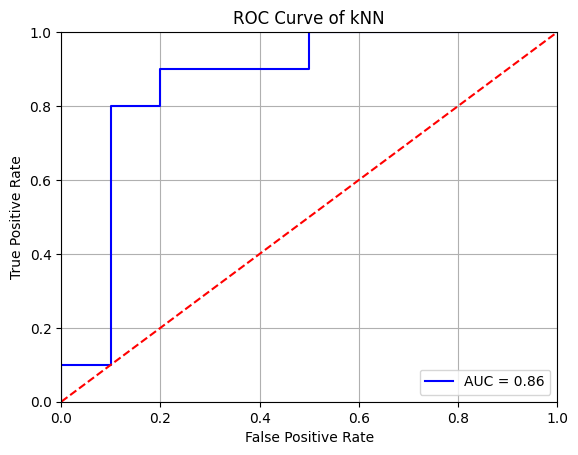

In [28]:
y_probabilities = np.array(y_probabilities)
# print(y_probabilities[:, 1])
fpr, tpr, threshold = roc_curve(test_label, y_probabilities[:, 1])
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
# EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
# print(EER)
EER = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER:", EER)
roc_auc = auc(fpr, tpr)
print("AUC Score:", roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.grid()
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.savefig("AUC-ROC Score")

print("Accuracy:", accuracy_score(test_label, y_predictions))
print("Precision:", precision_score(test_label, y_predictions))
print("Recall:", recall_score(test_label, y_predictions))
print("F1 score:", f1_score(test_label, y_predictions))